# Self-Attention and Positional Encoding

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

Positional Encoding 位置编码

## Self-Attention

In [2]:
# 定义隐藏层维度和多头注意力的头数
num_hiddens, num_heads = 100, 5 
# num_hiddens=100: 每个词向量的维度是100
# num_heads=5: 使用5个注意力头来并行计算注意力

# 创建多头注意力模块
attention = d2l.MultiHeadAttention(num_hiddens, num_heads, 0.5) 
# 第三个参数0.5是dropout率，用于防止过拟合

# 定义批次大小、查询数量和有效长度
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2]) 
# batch_size=2: 一个批次包含2个样本
# num_queries=4: 每个样本有4个查询位置（比如4个词）
# valid_lens=[3, 2]: 第一个样本有效长度为3，第二个样本有效长度为2

# 创建输入张量X，全1张量用于测试
X = torch.ones((batch_size, num_queries, num_hiddens)) 
# 形状: (2, 4, 100) 
# 这里用全1是为了测试，实际应用中X是词嵌入向量

# Self-Attention的核心：输入X同时作为查询(Q)、键(K)、值(V)
d2l.check_shape(attention(X, X, X, valid_lens), (batch_size, num_queries, num_hiddens))
# attention(X, X, X, valid_lens): 
#   - 第一个X作为查询(Query)
#   - 第二个X作为键(Key) 
#   - 第三个X作为值(Value)
#   - 这就是Self-Attention：自己跟自己计算注意力
# 输出形状检查: (2, 4, 100)，与输入形状相同

## Positional Encoding

```
什么是广播机制（Broadcasting）？
# 例子1：标量广播
    a = torch.tensor([1, 2, 3])        # 形状: (3,)
    b = 10                             # 标量
    result = a + b                     # 结果: [11, 12, 13]
# PyTorch自动将10广播成[10, 10, 10]来匹配a的形状

# 例子2：不同维度广播
    a = torch.tensor([[1, 2, 3],       # 形状: (2, 3)
                      [4, 5, 6]])   
    b = torch.tensor([10, 20, 30])     # 形状: (3,)
    result = a + b                     # 结果: [[11, 22, 33], [14, 25, 36]]
# PyTorch将b广播成[[10, 20, 30], [10, 20, 30]]

In [3]:
class PositionalEncoding(nn.Module):  
    """位置编码类"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        # 初始化函数
        # num_hiddens: 隐藏层维度（词嵌入维度）
        # max_len: 支持的最大序列长度，默认1000
        
        super().__init__()  # 调用父类初始化
        
        # 创建dropout层，用于正则化
        self.dropout = nn.Dropout(dropout)
        
        # 创建位置编码矩阵P，形状为(1, max_len, num_hiddens)
        # 第一个维度为1是为了后续广播
        self.P = torch.zeros((1, max_len, num_hiddens))
        
        # 生成位置索引，从0到max_len-1
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) 
        # reshape(-1, 1)将其变为列向量: [[0], [1], [2], ..., [max_len-1]]
        
        # 计算位置编码的分母部分
        # torch.arange(0, num_hiddens, 2): 生成[0, 2, 4, 6, ...] (偶数索引)
        # 除以num_hiddens后作为指数，再用10000为底计算幂
        X = X / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        
        # 对偶数位置的维度使用sin函数
        self.P[:, :, 0::2] = torch.sin(X)  # 0::2表示从0开始，步长为2，即偶数索引
        
        # 对奇数位置的维度使用cos函数  
        self.P[:, :, 1::2] = torch.cos(X)  # 1::2表示从1开始，步长为2，即奇数索引

    def forward(self, X):
        # 前向传播函数
        # X: 输入的词嵌入，形状为(batch_size, seq_len, num_hiddens)
        
        # 将位置编码加到词嵌入上
        # self.P[:, :X.shape[1], :] 取出前X.shape[1]个位置的编码
        # .to(X.device) 确保位置编码与输入X在同一设备上（CPU或GPU）
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        
        # 应用dropout并返回
        return self.dropout(X)

```
# 输入："我 爱 自然语言处理"（5个词）

# 1. 每个位置获得一个固定的、有规律的编码：
位置0: [sin(0), cos(0), sin(0/100), cos(0/100), ...]      # 100个数字
位置1: [sin(1), cos(1), sin(1/100), cos(1/100), ...]      # 100个数字
位置2: [sin(2), cos(2), sin(2/100), cos(2/100), ...]      # 100个数字
位置3: [sin(3), cos(3), sin(3/100), cos(3/100), ...]      # 100个数字
位置4: [sin(4), cos(4), sin(4/100), cos(4/100), ...]      # 100个数字

# 2. 这些编码不是随机的，而是有数学规律的！
# 3. 模型通过训练学会利用这些规律

```
位置编码与词嵌入相加：
# 在PositionalEncoding的forward方法中：
    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)  # ← 这里是加法！
        return self.dropout(X)

# 具体过程：
    词嵌入:    [0.1, 0.3, 0.5, 0.2]  # 词"猫"的语义向量
    位置编码:  [0.0, 1.0, 0.0, 1.0]  # 位置0的位置向量
    结果:      [0.1, 1.3, 0.5, 1.2]  # 直接相加！

```
# 输入："猫 吃 鱼"

# 第1步：每个词都有Q, K, V向量
"猫": Q_猫=[...], K_猫=[...], V_猫=[...]
"吃": Q_吃=[...], K_吃=[...], V_吃=[...]  
"鱼": Q_鱼=[...], K_鱼=[...], V_鱼=[...]

# 第2步：计算所有词对之间的注意力（这里有9个点积！）
"猫"的Q · "猫"的K = score_猫→猫  # 一个数字
"猫"的Q · "吃"的K = score_猫→吃  # 一个数字
"猫"的Q · "鱼"的K = score_猫→鱼  # 一个数字
"吃"的Q · "猫"的K = score_吃→猫  # 一个数字
"吃"的Q · "吃"的K = score_吃→吃  # 一个数字
"吃"的Q · "鱼"的K = score_吃→鱼  # 一个数字  
"鱼"的Q · "猫"的K = score_鱼→猫  # 一个数字
"鱼"的Q · "吃"的K = score_鱼→吃  # 一个数字
"鱼"的Q · "鱼"的K = score_鱼→鱼  # 一个数字

# 第3步：9个数字组成3×3矩阵
attention_matrix = [[score_猫→猫, score_猫→吃, score_猫→鱼],
                    [score_吃→猫, score_吃→吃, score_吃→鱼],
                    [score_鱼→猫, score_鱼→吃, score_鱼→鱼]]

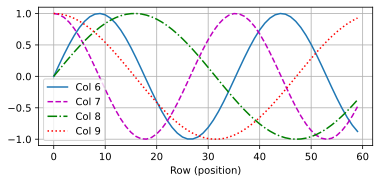

In [4]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

```
PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
------------------------------------------------------------------------------------------------
# 代码中的参数：
encoding_dim = 32  # 每个位置有32个数字
num_steps = 60     # 总共60个位置

# 所以实际的位置编码是这样的：
位置0:  [sin(0), cos(0), sin(0/100), cos(0/100), ..., ?, ?, ?, ?, ...]  # 32个数字
位置1:  [sin(1), cos(1), sin(1/100), cos(1/100), ..., ?, ?, ?, ?, ...]  # 32个数字  
位置2:  [sin(2), cos(2), sin(2/100), cos(2/100), ..., ?, ?, ?, ?, ...]  # 32个数字
...
位置59: [sin(59), cos(59), sin(59/100), cos(59/100), ..., ?, ?, ?, ?, ...] # 32个数字
------------------------------------------------------------------------------------------------
# i=0 (维度0,1)：
维度0: sin(1 / 10000^(0/32)) = sin(1 / 1) = sin(1) ≈ 0.841
维度1: cos(1 / 10000^(0/32)) = cos(1 / 1) = cos(1) ≈ 0.540

# i=1 (维度2,3)：  
维度2: sin(1 / 10000^(2/32)) = sin(1 / 4.64) ≈ sin(0.215) ≈ 0.213
维度3: cos(1 / 10000^(2/32)) = cos(1 / 4.64) ≈ cos(0.215) ≈ 0.977

# i=2 (维度4,5)：
维度4: sin(1 / 10000^(4/32)) = sin(1 / 10.0) = sin(0.1) ≈ 0.100
维度5: cos(1 / 10000^(4/32)) = cos(1 / 10.0) = cos(0.1) ≈ 0.995

# 所以位置1是: [0.841, 0.540, 0.213, 0.977, 0.100, 0.995, ...]
# 完全不同于位置0！

## Absolute Positional Information

In [5]:
for i in range(8):
    print(f'{i} in binary is {i:>03b}')

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


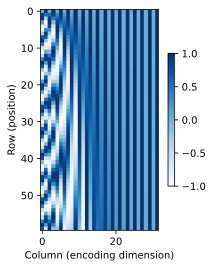

In [6]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')